# VQE（量子変分）アルゴリズム
現状の量子コンピュータはエラーが多いために、位相推定アルゴリズムをそのまま利用するには障壁があります。量子古典ハイブリッド計算で使えるVQEと呼ばれる手法が開発されました。

## VQEとは？
位相推定アルゴリズムの代わりにあるハミルトニアンの固有値を求めるためのアルゴリズムです。
固有値を求めるために量子コンピュータと古典コンピュータを交互に利用してパラメータを最適化します。


## 最適化するパラメータとは？
最適化するのは、波動関数に導入された回転角θです。θは連続的であればいいと思います。

## どうやって最適化するのか
最適化は非線形の古典の最適化アルゴリズムを使うのが一般的です。あるパラメータθで試した後に次のパラメータを試します。次のパラメータを試す際の選び方を古典の最適化アルゴリズム（ネルダーミードやベイズ最適化など）にお任せします。

## 変分原理とは？
E[ψ] = <ψ|H|ψ> >= E0

適当な境界条件を持つ任意の状態|ψ>に対するハミルトニアンHの期待値Eは、基底状態のエネルギーE0よりも常に大きいか等しい。
これを利用して、任意の状態でより基底状態に近いものを探索していきます。この任意の状態|ψ>の探索のためにパラメータθを導入して表現します。

## 実装方法
適当なパラメータθを割り振った初期の波動関数・状態ベクトルを用意し、ハミルトニアンHを用意します。状態ベクトルにHを作用させて、最終的に出てきた<ψ|H|ψ>を測定します。今度はその結果を使って、次のパラメータθを決めて再度繰り返し、一定の値に収束するまで繰り返します。今回はRY回転を使って実装をしたいと思います。

##ステップの確認
ステップを確認します。
１、状態ベクトルを初期化してRY(θ)回転を使って状態を操作する。
２、求めたいハミルトニアンHを適用する
３、測定してEを求める。
４、以下いろんなθで繰り返し計算を行なってEの低いのを探す
５、ある程度収束したら終了

ステップは慣れればできそうです。今回はせっかくなのでθを0から2πまで離散的に変化させてみます。

## ステップ１：RY(θ)回転
まずは回転をしてみます。今回はnumpy使って離散値20個を用意します。
回転角も離散値の参考で3番目の値を使ってみます。

In [0]:
import numpy as np
angle = np.linspace(0.0,2*np.pi,20)

c = Circuit().ry(angle[3])[0]

## ステップ２：ハミルトニアンHを適用
ハミルトニアンは自分の固有値を求めたい行列を入れますが、
今回はハミルトニアンとしてZを用意してみたいと思います。

In [0]:
c = Circuit().ry(angle[3])[0].z[0]

##ステップ３：測定してEを求める
こちらの計算を実行してみます。

In [23]:
c = Circuit().ry(angle[3])[0].z[0] 
c.run() 

array([ 0.87947375+0.j, -0.47594739+0.j])

状態ベクトルが出ました。通常はサンプリングを通じてEを出しますが、今回は状態ベクトルから計算してしまいます。今回求めたいのは、

<ψ|H|ψ>ですが、Zゲートをハミルトニアンとしたので、<ψ|[[1,0],[0,-1]]|ψ>を求めればよいことに。
|0><0| = [[1,0],[0,0]] |1><1| = [[0,0],[0,1]] より、H = Z = |0><0| - |1><1|ということで、 測定結果0-測定結果1の分布を求めれば大丈夫そうです。 上記状態ベクトルでは、 0.87947375*0.87947375 - 0.47594739*0.47594739 = 0.5469481588912504 となります。 Blueqatコードでは、

In [24]:
c = Circuit().ry(angle[3])[0].z[0] 
result = c.run()                                                                                                                    

print(np.abs(result[0])*np.abs(result[0])-np.abs(result[1])*np.abs(result[1]))  

0.5469481581224267


## ステップ４、５：繰り返してみます。
θを連続的に変化させてハミルトニアンを算出します。
これをすべてのアングルθで行います。
これまでのコードをまとめて掲載してみます。

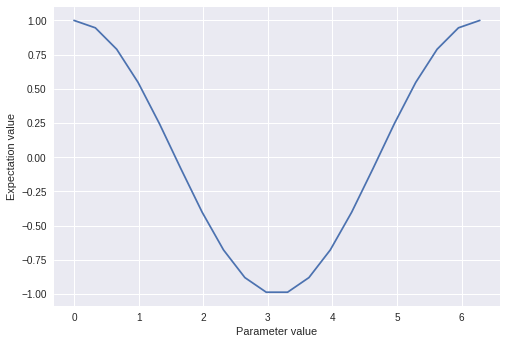

In [25]:
from blueqat import Circuit
import numpy as np
import matplotlib.pyplot as plt 

angle = np.linspace(0.0,2*np.pi,20) 
data = [0 for i in range(20)] 

for i in range(20): 
  c = Circuit().ry(angle[i])[0].z[0] 
  result = c.run() 
  data[i] = np.abs(result[0])*np.abs(result[0])-np.abs(result[1])*np.abs(result[1]) 

plt.xlabel('Parameter value') 
plt.ylabel('Expectation value') 
plt.plot(angle, data) 
plt.show() 

求めたいminimum valueがπあたりに-1があるのが確認できます。

## さらに本格的に使うには
Blueqatには上記のVQEをより本格的に実装しています。ハミルトニアンと呼ばれるときたいコスト関数を用意し、それをステップ数と一緒にvqeにかけます。


In [26]:
from blueqat import vqe
from blueqat.pauli import qubo_bit as q

hamiltonian = -3*q(0)-3*q(1)-3*q(2)-3*q(3)-3*q(4)+2*q(0)*q(1)+2*q(0)*q(2)+2*q(0)*q(3)+2*q(0)*q(4)+2*q(1)*q(2)+2*q(1)*q(3)+2*q(1)*q(4)+2*q(2)*q(3)+2*q(2)*q(4)+2*q(3)*q(4)
step = 2

result = vqe.Vqe(vqe.QaoaAnsatz(hamiltonian, step)).run()
print(result.most_common(12))

(((1, 1, 0, 0, 0), 0.06688115611022268), ((1, 0, 0, 1, 0), 0.06688115611022268), ((1, 0, 1, 0, 0), 0.06688115611022265), ((0, 1, 1, 0, 0), 0.06688115611022265), ((0, 1, 0, 1, 0), 0.06688115611022265), ((0, 0, 1, 1, 0), 0.06688115611022265), ((1, 0, 0, 0, 1), 0.06688115611022265), ((0, 1, 0, 0, 1), 0.06688115611022265), ((0, 0, 1, 0, 1), 0.06688115611022265), ((0, 0, 0, 1, 1), 0.06688115611022265), ((0, 0, 0, 0, 1), 0.03201256823923941), ((1, 0, 0, 0, 0), 0.0320125682392394))
